In [ ]:
from pysolar import solar
from datetime import datetime, timezone, timedelta
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize_scalar, minimize, Bounds
from enn554.utilities import read_TMY
from enn554.math import cosd
import enn554.parabolic_trough as pt


# Solving for absorber temperature for the "naked" absorber model

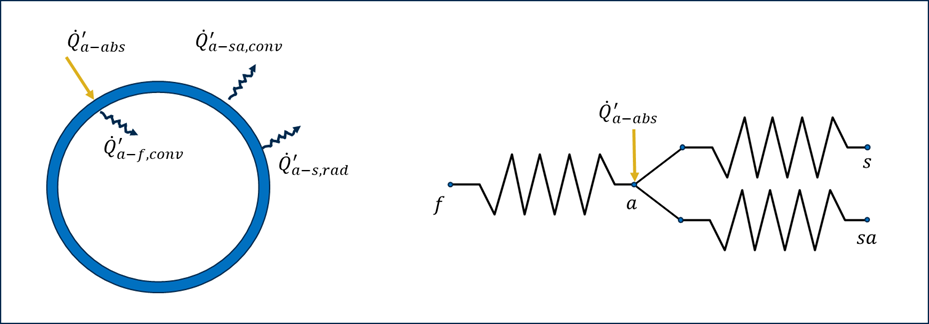

In [ ]:
plant = pt.parabolic_trough_1D_transient()
plant.import_material_parameters('data/parabolic_trough_parameters - PST.csv')

to_kelvin = lambda t: t+273.15
to_celcius = lambda t: t-273.15

T_ambient = 22 # C
γ_axis = 0 # north-south orientation, +ve west
T_sky = T_ambient - 8 # According to [1] 
L_aperture = 100 # shouldn't matter for 1D
massflow = 10 # kg/s
T = [150, 160,160]
T = [to_kelvin(t) for t in T]
wind_speed = 5
IAM = lambda θ: cosd(θ) + 0.000884*θ - 0.00005369*θ**2 # incidence angle modifier [2, p. 12]. 
η_opt = 0.81


In [ ]:
def residuals(T,DNI,θ):
    Q_a_abs,_ = plant.solar_heating_rates(DNI,η_opt*IAM(θ))
    Q_af_conv = plant.absorber_to_htf_convection(T,massflow)
    Q_asa_conv = plant.envelope_to_surroundings_convection(T,to_kelvin(T_ambient),wind_speed)
    Q_as_rad = plant.envelope_to_surroundings_radiation(T,to_kelvin(T_sky))
    res = Q_a_abs - Q_af_conv - Q_asa_conv - Q_as_rad
    return res,[Q_a_abs,Q_af_conv,Q_asa_conv,Q_as_rad]

I will fix the absorber temperature to the envelope temperature together and set the absorber and envelope properties to "trick" the functions into the naked absorber case. 

In [ ]:
plant.absorber['eta_opt'] = 1.0
for f in plant.envelope.keys():
    plant.envelope[f] = plant.absorber[f]
plant.envelope['transmittance'] = 1.0

DNI,θ = 950,0
bnd = Bounds((286),(670), keep_feasible=True)
fun = lambda x: sum(residuals([T[0],x,x],DNI,θ)[0]**2) 
sol = minimize(fun,T[1],bounds=bnd)
to_celcius(sol.x)

# Sun position at solstice for a given location
The below computed the design sun position to be used in SolarPILOT for the field design in the tutorial. Note that pysolar uses 0 at north and positive angles east of north up to 360, see [here](https://pysolar.readthedocs.io/en/latest/#examples). This is the same convention as Solar Pilot.

In [ ]:
tmy,metadata = read_TMY('data/woomera_tmy.csv')
lat,lon = metadata['Latitude'],metadata['Longitude']
utc_offset = metadata['Time Zone']
t0 = datetime(2023,9,23,0,0,0,tzinfo=timezone(timedelta(hours=utc_offset)))
# t0 = datetime(2023,12,22,0,0,0,tzinfo=timezone(timedelta(hours=utc_offset)))
times = [t0+timedelta(minutes=15*h) for h in range(96)] 
angles = [solar.get_position(lat,lon,t) for t in times]
θ_z = np.array([90-a[1] for a in angles])
γ_s = [a[0] for a in angles] 

In [ ]:
ind = np.argmin(np.abs(θ_z))
t,az,zenith = times[ind],γ_s[ind],θ_z[ind]
print(f'Sun location: (az={az:.2f},elevation={90-zenith:.2f}) on {t.time()} on {t.date()}')